In [1]:
import sys
sys.path.append(r"C:\Users\49174\anaconda3\envs\praktikum\Lib\site-packages")
import torch
import numpy as np
from dataset_jacquard_samples import JacquardSamples
from utils import get_transform, get_inv_transform
from bce_model import BCEGraspTransformer
from utils_train import create_correct_false_points
import random
from pytorch_lightning.loggers import TensorBoardLogger
import matplotlib.pyplot as plt

xFormers not available
xFormers not available


jaq root /home/cedric/ZeroShot-Grasping/MLP-approach/Jacquard_fence/Samples/


In [2]:
args_infer = {
    "model_path" : "runs/grasp_valid.ckpt",
    "device" : "cuda",
    "img_size" : 840
}

In [11]:
device = torch.device(args_infer["device"])
image_transform = get_transform()
inv_transform = get_inv_transform()
model = BCEGraspTransformer(img_size=840,int_dim=256,output_dim=128)
dataset = JacquardSamples(image_transform=image_transform, num_targets=5, overfit=False,
                              img_size=args_infer["img_size"])
model.load_state_dict(torch.load(args_infer["model_path"]))
model = model.to(device)

In [7]:
test_idx =4
data = dataset[test_idx]
img = data["img"].to(device)
img = torch.permute(img, (0, 2, 1))
grasp = data["points_grasp"]//14
grasp_inv = torch.cat([grasp[:,1,:].unsqueeze(1), grasp[:,0,:].unsqueeze(1)], dim=1)
grasp = torch.cat([grasp, grasp_inv], dim=0)

In [8]:
features = model.forward_dino_features(img.unsqueeze(0)).squeeze().reshape(60, 60, 384)

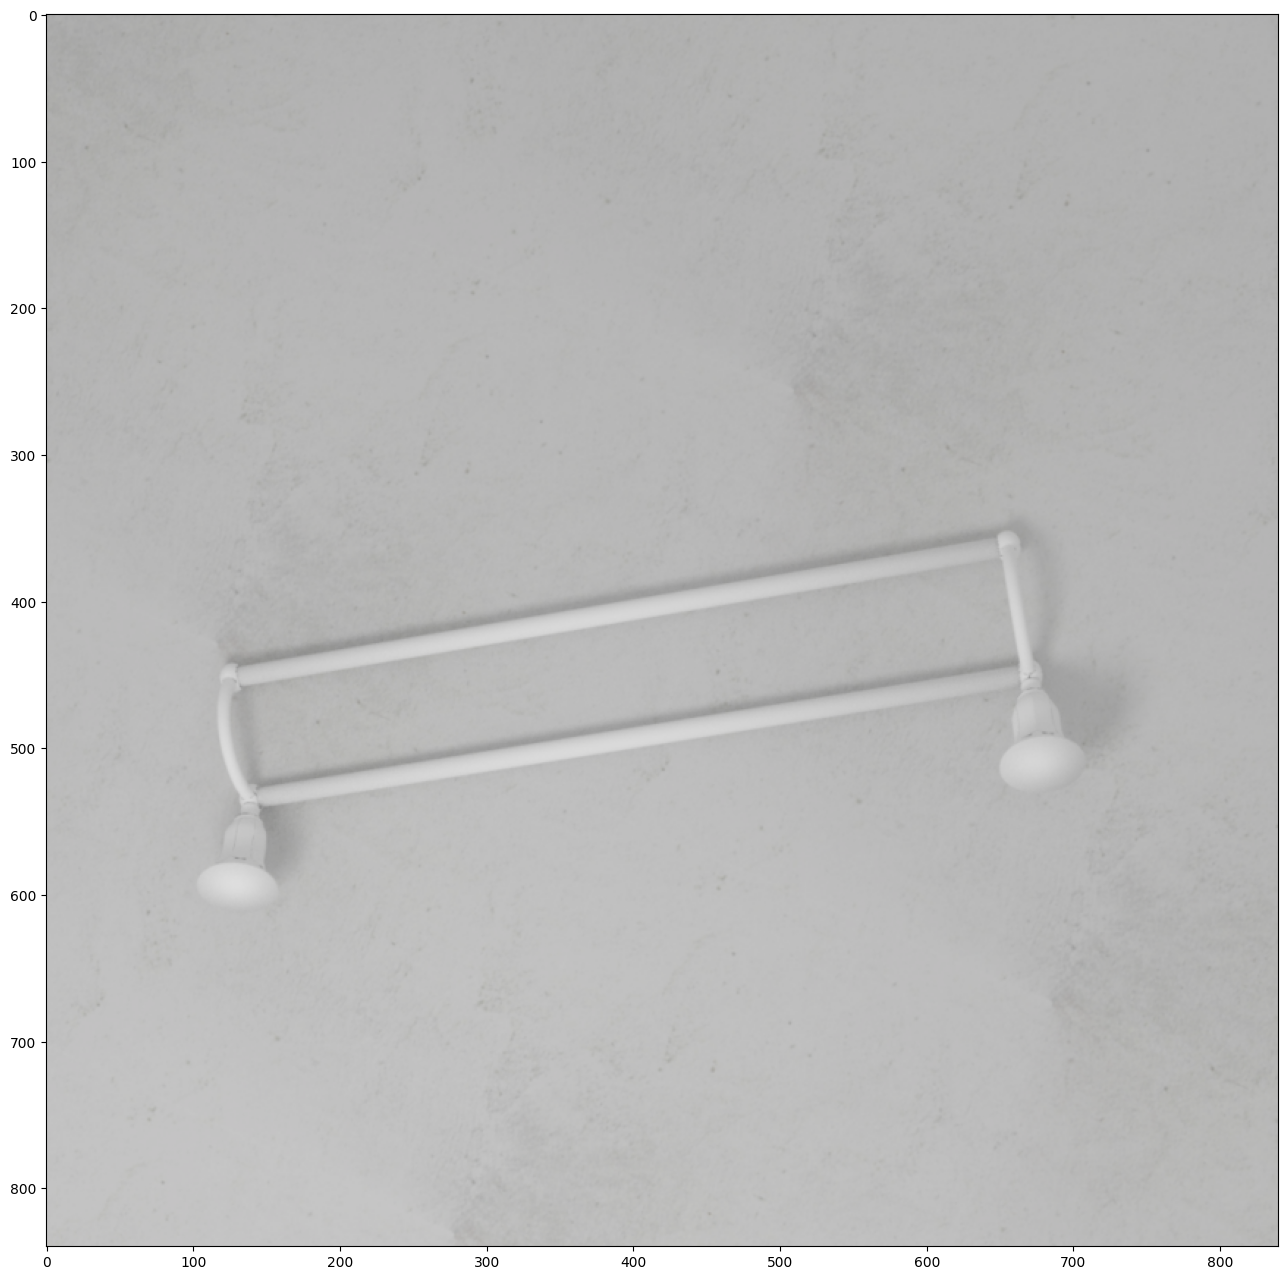

In [9]:
plt.figure(figsize=(16,16))
org_image = torch.permute(inv_transform(img), (1, 2, 0)).cpu().numpy()
plt.imshow(org_image)

# Test gt points certainty

In [12]:
all_points = grasp
mean_feats=[]
diffs = []
patch_area = 1
for i in range(all_points.shape[0]):
    pt1 = all_points[i,0,:]
    pt2 = all_points[i,1,:]
                    
    features_1 = features[pt1[0]:pt1[0]+patch_area, pt1[1]:pt1[1]+patch_area, :]
    features_1 = features_1.reshape(features_1.shape[0] * features_1.shape[1], features_1.shape[2]).mean(0)
    
    features_2 = features[pt2[0]:pt2[0]+patch_area, pt2[1]:pt2[1]+patch_area, :]
    features_2 = features_2.reshape(features_2.shape[0] * features_2.shape[1], features_2.shape[2]).mean(0)
    
                
    if i == 0:
        mean_feats = features_1.unsqueeze(0)
        mean_feats = torch.cat([mean_feats, features_2.unsqueeze(0)], dim=0)
    else:
        mean_feats = torch.cat([mean_feats, features_1.unsqueeze(0)], dim=0)
        mean_feats = torch.cat([mean_feats, features_2.unsqueeze(0)], dim=0)
with torch.no_grad():
    preds = model.forward_valid(mean_feats.to(device))

In [13]:
print(preds.mean())

tensor(0.4987, device='cuda:0')


# Test single point

In [32]:

all_points = torch.tensor([[i,j] for j in range(60) for i in range(60)]).unsqueeze(1).to(device)
print(all_points.shape)
print(all_points[0])
#all_points = all_points.reshape(1,2,1)
#all_points = torch.cat([single_point, all_points], dim=1).to(device)

torch.Size([3600, 1, 2])
tensor([[0, 0]], device='cuda:0')


In [38]:
mean_feats=[]
diffs = []
for i in range(all_points.shape[0]):
    pt1 = all_points[i,0,:]
                    
    features_1 = features[pt1[0]:pt1[0]+patch_area, pt1[1]:pt1[1]+patch_area, :]
    features_1 = features_1.reshape(features_1.shape[0] * features_1.shape[1], features_1.shape[2]).mean(0)

                
    if i == 0:
        mean_feats = features_1.unsqueeze(0)
    else:
        mean_feats = torch.cat([mean_feats, features_1.unsqueeze(0)], dim=0)
with torch.no_grad():
    preds = model.forward_valid(mean_feats.to(device))

preds = preds.squeeze().reshape(60, 60).unsqueeze(0).unsqueeze(0)
preds = torch.nn.functional.interpolate(preds, (840, 840), mode="nearest").squeeze()
preds = torch.permute(preds, (1, 0))

In [39]:
#preds[preds!=preds.max()] = 0
#preds[preds>0] = 1
preds.shape

torch.Size([840, 840])

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


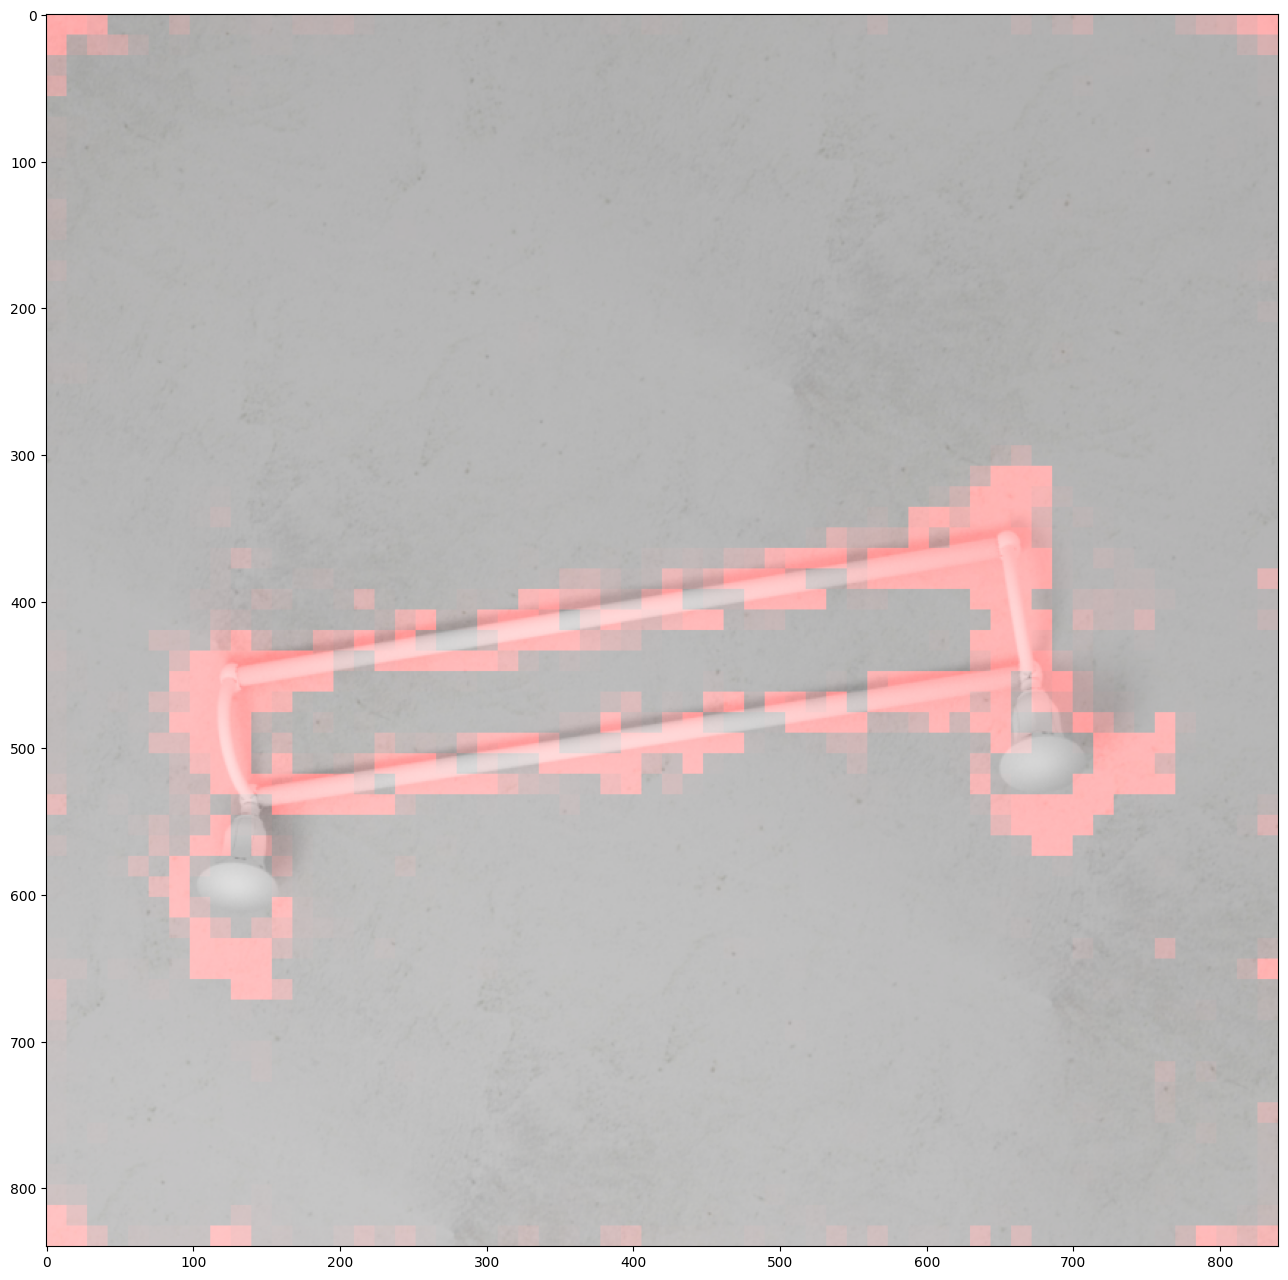

In [40]:
zeros = torch.zeros(840, 840, 1)
preds = torch.cat([preds.cpu().detach().unsqueeze(2), zeros, zeros], dim = 2)
#origin_point = np.zeros((3, 60, 60))
#origin_point[:, single_point[0][0][0], single_point[0][0][1]] = [0, 1, 0]
#origin_point = torch.nn.functional.interpolate(torch.tensor(origin_point).unsqueeze(0), (840, 840), mode="nearest").squeeze()
#origin_point = torch.permute(origin_point,(1, 2, 0)).cpu().detach().numpy()

plt.figure(figsize=(16,16))
show_img = org_image + 0.7*preds.cpu().detach().numpy() 
#show_img = org_image + 0.7*origin_point2 + 0.7*origin_point
plt.imshow(show_img)